In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from data import BraTSDataset

from IPython.display import HTML

In [2]:
def compute_psnr(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    psnr_val = 0.0
    for i in range(b_size):
        psnr_val += psnr(
            real_batch[i, :, :, :].transpose(1, 2, 0),
            fake_batch[i, :, :, :].transpose(1, 2, 0),
            data_range=1.0,
        )
    return psnr_val / b_size

In [3]:
def compute_ssim(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    ssim_val = 0.0
    for i in range(b_size):
        ssim_val += ssim(
            real_batch[i, :, :, :],
            fake_batch[i, :, :, :],
            channel_axis=0,
            data_range=1.0,
        )
    return ssim_val / b_size

In [4]:
seed = 999
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Dataset configuration
dataset_root = "dataset"
t1_train_data = "data/MICCAI_BraTS2020/train/t1"
# Original image size is 240, so compress by 4 time
image_size = 64
num_workers = 16

# Critic model configuration
use_gp = False
lambda_gp = 10
# clipping param won't be used if use_gp is True
clipping_param = 0.01

# Generator model configuration
latent_size = 128
feature_map_size = image_size

# Training configuration
device = torch.device("cuda:0")
batch_size = 32
n_epochs = 100
n_critic = 5
lr = 0.001
beta1 = 0.5

In [6]:
image_paths = [os.path.join(t1_train_data, impath) for impath in os.listdir(t1_train_data)]
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    ])
dataset = BraTSDataset(image_paths, tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [7]:
real_batch = next(iter(dataloader))

torch.Size([32, 1, 64, 64])


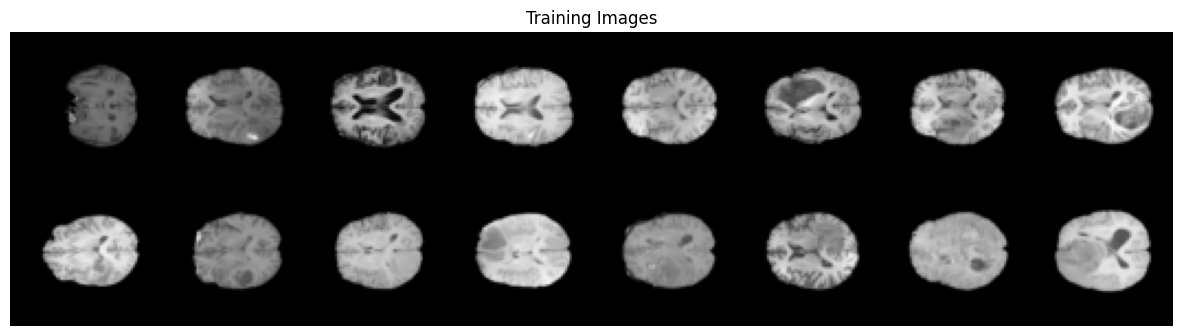

In [8]:
# Plot some training images
print(real_batch.shape)
# Actually plot it
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch.to(device)[:16], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [9]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [10]:
class Critic(nn.Module):
    def __init__(self, use_gp=False) -> None:
        super(Critic, self).__init__()
        if use_gp:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
        else:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 2),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 4),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 8),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
    
    def forward(self, input):
        return self.main(input)

In [11]:
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [12]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*16 x image_size/16 x image_size/16
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*8 x image_size/8 x image_size/8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*4 x image_size/4 x image_size/4
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*2 x image_size/2 x image_size/2
            nn.ConvTranspose2d(feature_map_size, 1, 4, 2, 1),
            nn.Tanh(),
            # output: 1 x image_size x image_size
        )
    
    def forward(self, input):
        return self.main(input)

In [13]:
generator_model = Generator().to(device)
generator_model.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [14]:
optimizer_generator = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training loop
print("Starting training....")
fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)
img_list = list()
d_loss_hist = list()
g_loss_hist = list()
psnr_hist = list()
best_psnr = -float("inf")
best_g_weights = None
best_d_weights = None

print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Get batch of data
        real_batch = data.to(device)
        b_size = real_batch.shape[0]
        if b_size != batch_size:
            # drop last batch
            continue

        d_loss_vals = list()
        for _ in range(n_critic):
            # Train critic weight for real images
            critic_model.zero_grad()
            d_loss_real = critic_model(real_batch)

            # Update critic weight for fake images
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake_batch = generator_model(noise)
            d_loss_fake = critic_model(fake_batch)

            d_loss = -torch.mean(d_loss_real - d_loss_fake)
            if use_gp:
                # Random weight term for interpolation
                alpha = torch.rand(b_size, 1, 1, 1).to(device)
                # Get random interpolations between real and fake
                interpolates = torch.autograd.Variable(alpha * real_batch + (1 - alpha) * fake_batch, requires_grad=True).to(device)
                d_interpolates = critic_model(interpolates)
                fake = torch.autograd.Variable(torch.Tensor(d_interpolates.size()).fill_(1.0), requires_grad=False).to(device)
                # Get gradient w.r.t interpolates
                gradients = torch.autograd.grad(
                    outputs=d_interpolates,
                    inputs=interpolates,
                    grad_outputs=fake,
                    create_graph=True,
                )[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += lambda_gp * gradient_penalty
            d_loss_vals.append(d_loss.detach().cpu().numpy())
            d_loss.backward()
            optimizer_critic.step()

            if use_gp:
                # no op
                ...
            else:
                # Clamp critic weights
                for p in critic_model.parameters():
                    p.data.clamp_(-clipping_param, clipping_param)
        
        d_loss_hist.append(np.mean(d_loss_vals))

        # Update generator weight
        generator_model.zero_grad()
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake_batch = generator_model(noise)
        output = critic_model(fake_batch)
        g_loss = -torch.mean(output)
        g_loss_hist.append(g_loss.detach().cpu().numpy())
        g_loss.backward()
        optimizer_generator.step()

        # Save best model based on PSNR every iteration
        psnr_hist.append(
            compute_psnr(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        if psnr_hist[-1] > best_psnr:
            best_psnr = psnr_hist[-1]
            best_g_weights = generator_model.state_dict()
            best_d_weights = critic_model.state_dict()

    tqdm.write("\n".join((
        f"epoch: {epoch}, d_loss: {d_loss_hist[-1]:.4f}, g_loss: {g_loss_hist[-1]:.4f} ",
        f"psnr: {psnr_hist[-1]:.4f}, best_psnr: {best_psnr:.4f}"
    )))

    # Check how the generator is doing by saving G's output on fixed_noise
    # with torch.no_grad():
    #     fake = generator_model(fixed_noise).detach().cpu()
    # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting training....
Number of mini batch iterations per epoch: 12


0it [00:00, ?it/s]MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_14.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
12it [00:44,  3.74s/it]

epoch: 0, d_loss: -0.4589, g_loss: 0.2706 
psnr: 8.2506, best_psnr: 8.7698



12it [00:06,  1.82it/s]

epoch: 1, d_loss: -0.8420, g_loss: 0.3676 
psnr: 7.4832, best_psnr: 8.7698



12it [00:06,  1.81it/s]

epoch: 2, d_loss: -0.4572, g_loss: 0.1414 
psnr: 11.4801, best_psnr: 11.4801



12it [00:06,  1.80it/s]

epoch: 3, d_loss: -0.5665, g_loss: 0.1631 
psnr: 12.4517, best_psnr: 12.4517



12it [00:06,  1.84it/s]

epoch: 4, d_loss: -0.4233, g_loss: -0.1675 
psnr: 13.2719, best_psnr: 13.3664



12it [00:06,  1.81it/s]

epoch: 5, d_loss: -0.4220, g_loss: 0.4265 
psnr: 13.8723, best_psnr: 14.0149



12it [00:06,  1.85it/s]

epoch: 6, d_loss: -0.3824, g_loss: 0.0845 
psnr: 13.8849, best_psnr: 14.0149



12it [00:06,  1.75it/s]

epoch: 7, d_loss: -0.3380, g_loss: 0.4425 
psnr: 12.7487, best_psnr: 14.0149



12it [00:06,  1.81it/s]

epoch: 8, d_loss: -0.4378, g_loss: 0.5412 
psnr: 12.7755, best_psnr: 14.0149



12it [00:06,  1.83it/s]

epoch: 9, d_loss: -0.4062, g_loss: 0.0158 
psnr: 13.3035, best_psnr: 14.0149



12it [00:06,  1.85it/s]

epoch: 10, d_loss: -0.5477, g_loss: 0.1530 
psnr: 13.1319, best_psnr: 14.0153



12it [00:06,  1.82it/s]

epoch: 11, d_loss: -0.5830, g_loss: 0.5463 
psnr: 13.3230, best_psnr: 14.2814



12it [00:06,  1.84it/s]

epoch: 12, d_loss: -0.6922, g_loss: 0.3662 
psnr: 13.9742, best_psnr: 14.2814



12it [00:06,  1.74it/s]

epoch: 13, d_loss: -0.4282, g_loss: 0.2767 
psnr: 13.2718, best_psnr: 14.5407



12it [00:06,  1.78it/s]

epoch: 14, d_loss: -0.6018, g_loss: 0.3282 
psnr: 13.2526, best_psnr: 14.5407



12it [00:06,  1.88it/s]

epoch: 15, d_loss: -0.5597, g_loss: 0.5122 
psnr: 13.6163, best_psnr: 14.5407



12it [00:06,  1.85it/s]

epoch: 16, d_loss: -0.5636, g_loss: 0.2257 
psnr: 13.2333, best_psnr: 14.6687



12it [00:06,  1.77it/s]

epoch: 17, d_loss: -0.7019, g_loss: 0.5216 
psnr: 13.5400, best_psnr: 14.7102



12it [00:06,  1.83it/s]

epoch: 18, d_loss: -0.5076, g_loss: 0.5457 
psnr: 12.9837, best_psnr: 14.7102



12it [00:06,  1.77it/s]

epoch: 19, d_loss: -0.6925, g_loss: 0.5702 
psnr: 14.2161, best_psnr: 14.7102



12it [00:06,  1.85it/s]

epoch: 20, d_loss: -0.4622, g_loss: 0.5346 
psnr: 14.1727, best_psnr: 14.7102



12it [00:06,  1.74it/s]

epoch: 21, d_loss: -0.6346, g_loss: 0.4692 
psnr: 14.1301, best_psnr: 14.7102



12it [00:06,  1.83it/s]

epoch: 22, d_loss: -0.7449, g_loss: 0.4683 
psnr: 14.1909, best_psnr: 14.7102



12it [00:06,  1.75it/s]

epoch: 23, d_loss: -0.8599, g_loss: 0.5533 
psnr: 14.2028, best_psnr: 14.7102



12it [00:06,  1.86it/s]

epoch: 24, d_loss: -0.5862, g_loss: 0.1814 
psnr: 13.4202, best_psnr: 14.7102



12it [00:06,  1.76it/s]

epoch: 25, d_loss: -0.7985, g_loss: 0.5530 
psnr: 14.1374, best_psnr: 14.7102



12it [00:06,  1.95it/s]

epoch: 26, d_loss: -1.0166, g_loss: 0.5260 
psnr: 13.6544, best_psnr: 14.7102



12it [00:06,  1.82it/s]

epoch: 27, d_loss: -0.5972, g_loss: 0.1086 
psnr: 13.9473, best_psnr: 14.7513



12it [00:06,  1.88it/s]

epoch: 28, d_loss: -0.7356, g_loss: 0.4440 
psnr: 14.5783, best_psnr: 14.9562



12it [00:06,  1.82it/s]

epoch: 29, d_loss: -0.7236, g_loss: 0.5543 
psnr: 13.5937, best_psnr: 14.9562


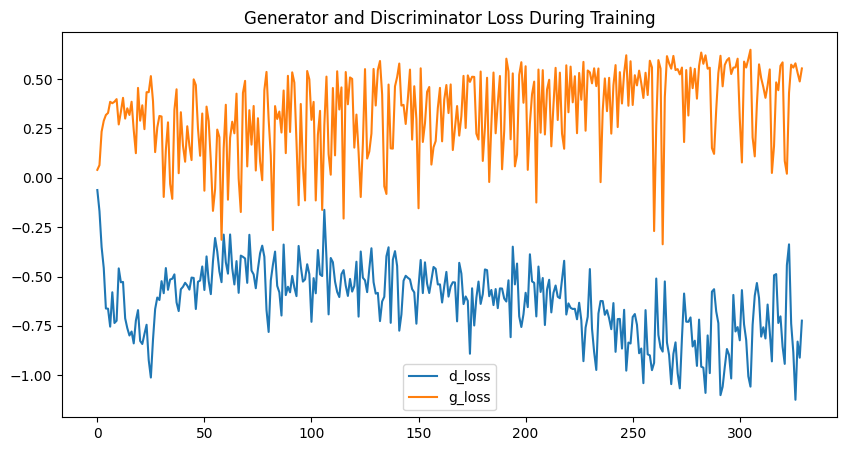

In [16]:
# Plot training history
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_loss_hist, label='d_loss')
plt.plot(g_loss_hist, label='g_loss')
plt.legend()
plt.show()

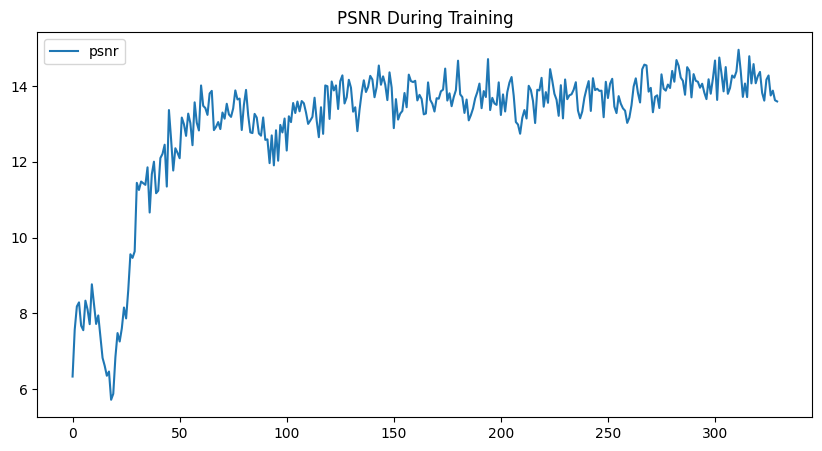

Best PSNR: 14.956202322851333


In [17]:
plt.figure(figsize=(10,5))
plt.title("PSNR During Training")
plt.plot(psnr_hist, label='psnr')
plt.legend()
plt.show()
print(f"Best PSNR: {best_psnr}:.4f")

In [18]:
# fig = plt.figure(figsize=(15,15))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[-50:]]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

In [19]:
# Save models weights
# model dir should be models/wgan_hr_mm_dd_mm
model_dir = "models/wgan_20_22_29_11"
torch.save(best_d_weights, f"{model_dir}/discriminator.pth")
torch.save(best_g_weights, f"{model_dir}/generator.pth")

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4,

(-0.5, 529.5, 133.5, -0.5)

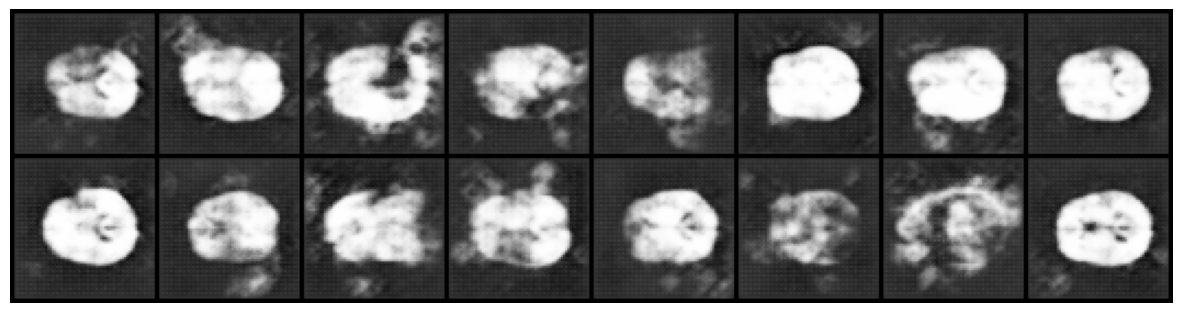

In [20]:
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "models/wgan_20_22_29_11"

# Load model and perform inference
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)
print(critic_model)

generator_model = Generator().to(device)
generator_model.apply(weight_init)
print(generator_model)

critic_model.load_state_dict(torch.load(f"{model_dir}/discriminator.pth"))
generator_model.load_state_dict(torch.load(f"{model_dir}/generator.pth"))

generator_model.eval()

fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

fake = generator_model(fixed_noise).detach().cpu()

plt.figure(figsize=(15, 15))
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.axis("off")